# Creating Augemented Images

In [1]:

import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import cv2
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import random


In [2]:
from keras.preprocessing import image

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [17]:
csv_file = "../data/train_labels.csv"
csv_file_2 = "../data/train_labels_2.csv"

df_1 = pd.read_csv(csv_file)
df_2 = pd.read_csv(csv_file_2)
df = pd.concat([df_1, df_2], ignore_index=True, )

In [18]:
df 

,Pothole number,Bags used
0,101,0.5
1,102,1.0
2,106,0.5
3,107,0.5
4,109,0.5
...,...,...
1079,1682,2.0
1080,1683,1.5
1081,1684,1.0
1082,1685,1.5


In [19]:
df['txt_file'] = 'p' + df['Pothole number'].astype(str) + '.txt'
df['img_file'] = 'p' + df['Pothole number'].astype(str) + '.jpg'

In [20]:
df['img_file']

0        p101.jpg
1        p102.jpg
2        p106.jpg
3        p107.jpg
4        p109.jpg
          ...    
1079    p1682.jpg
1080    p1683.jpg
1081    p1684.jpg
1082    p1685.jpg
1083    p1686.jpg
Name: img_file, Length: 1084, dtype: object

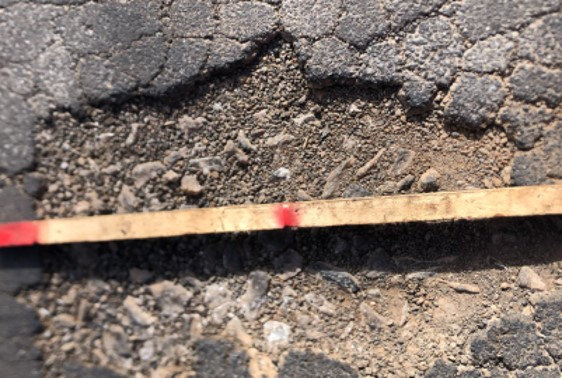

In [21]:
Image.open('../data/train_images/p101.jpg')

In [28]:
valid = [] 
for file in df['img_file']:
    name = '../data/train_images/' + file 
    name_2 = '../data/train_images_2/' + file 
    if os.path.exists(name):
        valid.append(file)
    elif os.path.exists(name_2):
        valid.append(file)

In [29]:
len(valid)

1009

In [30]:
valid_df = df[df['img_file'].isin(valid)]

valid_df = valid_df[['img_file', 'Bags used ']]
valid_df.rename(columns={'Bags used ': 'bags_used'}, inplace=True)

In [31]:
valid_df

,img_file,bags_used
0,p101.jpg,0.5
1,p102.jpg,1.0
2,p106.jpg,0.5
3,p107.jpg,0.5
4,p109.jpg,0.5
...,...,...
1079,p1682.jpg,2.0
1080,p1683.jpg,1.5
1081,p1684.jpg,1.0
1082,p1685.jpg,1.5


In [32]:
import tensorflow as tf

In [5]:
IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()


In [6]:
class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    

In [7]:
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(pattern)],
        compression_type='GZIP'
    ).map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label))                             
    return trainds

In [110]:
def add_randomness_to_colors_tf(image):
    color_shift_range = tf.random.uniform([], 0, 20, dtype=tf.float32)

    # Convert the image to a float32 tensor and normalize the values to [0, 1]
    img_tensor = tf.image.convert_image_dtype(image, tf.float32)

    # Generate random shifts for each color channel
    random_shift = tf.random.uniform(tf.shape(img_tensor), -color_shift_range/255.0, color_shift_range/255.0)

    # Add the random shift and clip values to stay within valid range [0, 1]
    img_tensor = tf.clip_by_value(img_tensor + random_shift, 0.0, 1.0)

    # Convert back to the original data type
    img_tensor = tf.image.convert_image_dtype(img_tensor, tf.uint8)

    return img_tensor

In [111]:
def soften_edges_tf(image):
    blur_radius = tf.random.uniform([], 0, 3, dtype=tf.float32)

    # Create a Gaussian kernel for blurring
    size = tf.cast(blur_radius * 4 + 1, tf.int32)  # kernel size proportional to the blur radius
    sigma = blur_radius / 2.0  # standard deviation

    # Create 1D Gaussian kernel
    x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
    g = tf.exp(-tf.pow(x, 2) / (2 * tf.pow(sigma, 2)))
    g = g / tf.reduce_sum(g)

    # Create 2D Gaussian kernel by outer product
    gaussian_kernel = tf.tensordot(g, g, axes=0)
    gaussian_kernel = gaussian_kernel[:, :, tf.newaxis, tf.newaxis]

    # Duplicate the kernel for each channel
    gaussian_kernel = tf.tile(gaussian_kernel, [1, 1, 3, 1])

    # Expand image dimensions to include batch size for filtering
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize image to [0, 1]

    # Apply Gaussian blur using convolution
    softened_image = tf.nn.depthwise_conv2d(
        image,
        gaussian_kernel,
        strides=[1, 1, 1, 1],
        padding='SAME'
    )

    # Remove batch dimension and convert back to original data type
    softened_image = tf.squeeze(softened_image, axis=0)
    softened_image = tf.image.convert_image_dtype(softened_image, tf.uint8)

    return softened_image

In [112]:
def create_gaussian_kernel(kernel_size, sigma, channels):
    """Create a Gaussian kernel."""
    kernel_range = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=tf.float32)
    kernel_1d = tf.exp(-0.5 * (kernel_range ** 2) / (sigma ** 2))
    kernel_1d /= tf.reduce_sum(kernel_1d)
    
    kernel_2d = tf.matmul(tf.reshape(kernel_1d, (-1, 1)), tf.reshape(kernel_1d, (1, -1)))
    kernel_2d = tf.expand_dims(kernel_2d, axis=-1)  # Add channel dimension
    kernel_2d = tf.tile(kernel_2d, [1, 1, channels, 1])  # Replicate across channels
    
    return kernel_2d

def soften_edges_tf(images):
    """Apply Gaussian blur to the images tensor."""
    # Convert images to float32 and normalize to [0, 1] range
    images = tf.image.convert_image_dtype(images, tf.float32)
    
    # Ensure tensor is of rank 4
    images = tf.ensure_shape(images, [None, None, None, 3])
    
    kernel_size = 5
    sigma = 1.0
    
    # Create Gaussian kernel with shape [kernel_size, kernel_size, channels, 1]
    gaussian_kernel = create_gaussian_kernel(kernel_size, sigma, channels=3)
    
    # Apply Gaussian blur using depthwise convolution
    softened_image = tf.nn.depthwise_conv2d(
        images,
        gaussian_kernel,
        strides=[1, 1, 1, 1],
        padding='SAME'
    )
    
    return softened_image

In [113]:
def add_randomness_to_colors_tf(image):
    color_shift_range = tf.random.uniform([], 0, 15, dtype=tf.float32)

    # Convert the image to a float32 tensor and normalize the values to [0, 1]
    img_tensor = tf.image.convert_image_dtype(image, tf.float32)

    # Generate random shifts for each color channel
    random_shift = tf.random.uniform(tf.shape(img_tensor), -color_shift_range/255.0, color_shift_range/255.0)

    # Add the random shift and clip values to stay within valid range [0, 1]
    img_tensor = tf.clip_by_value(img_tensor + random_shift, 0.0, 1.0)

    # Convert back to the original data type
    img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)

    return img_tensor

In [114]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.4, 1.5], 
                 brightness_delta=[-0.2, 0.3],
                 hue_delta=[-0.1, 0.1],
                 jpeg_qual = [40,100],
                 **kwargs):
        super(Augment, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
        self.hue_delta = hue_delta
        self.jpeg_qual = jpeg_qual
    
    def ensure_rank_4(self, images):
        """Ensure that the images tensor has rank 4."""
        if len(images.shape) == 3:
            # If the image is rank 3 (height, width, channels), add a batch dimension
            images = tf.expand_dims(images, axis=0)
        elif len(images.shape) == 5:
            # If the image is rank 5 (batch_size, height, width, channels, extra), squeeze out the extra dimension
            images = tf.squeeze(images, axis=-1)
        return images
    
    def call(self, images, training=None):
        if not training:
            return images
        
        images = self.ensure_rank_4(images)
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        hue = np.random.uniform(
            self.hue_delta[0], self.hue_delta[1])
        jpeg = random.randint(
            self.jpeg_qual[0], self.jpeg_qual[1])
        flip_u = random.randint(0,2)
        flip_l = random.randint(0,2)
        
        contr = random.randint(0,2)
        bright = random.randint(0,2)

        ad_hue = random.randint(0,2)
        j_q = random.randint(0,2)

        rand_col = random.randint(0,2)
        soft = random.randint(0,2)


        if (contr == 1) :images = tf.image.adjust_contrast(images, contrast)
        if (bright == 1) :images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        if (ad_hue == 1) :images = tf.image.adjust_hue(images, hue)
        #if (j_q== 1) :images = tf.image.adjust_jpeg_quality(images, jpeg, dct_method='')
        if (rand_col == 1) :images = add_randomness_to_colors_tf(images)
        #if (soft == 1) :images = soften_edges_tf(images)
        if (flip_l == 1) : images = tf.image.flip_left_right(images)
        if (flip_u == 1) : images = tf.image.flip_up_down(images)
        


        return images

In [118]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd



# Define image dimensions
img_width, img_height = 256, 256

# Preprocess images and load into arrays
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Load and preprocess images
X = np.array([preprocess_image('../data/padded_images/resized' + file) for file in valid_df['img_file']])
y = valid_df['bags_used'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


FileNotFoundError: [Errno 2] No such file or directory: '../data/padded_images/resizedp101.jpg'

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

In [116]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best loss
)

In [59]:
augment_layer = Augment()

model = Sequential([
    InputLayer(input_shape=(256, 256, 3)),  # Replace with your input image size
    augment_layer,  # Add the augmentation layer here
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Regression output for predicting 'bags_used'
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Summary of the model
model.summary()


/Users/steffanschoonbee/Documents/Studies/Hackathon/StandardBankHackathon/notebook/venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augment_9 (Augment)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 125, 125, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,872,833 (7.14 MB)

 Trainable params: 1,872,833 (7.14 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
augment_layer = Augment()

model2 = Sequential([
    InputLayer(input_shape=(256, 256, 3)),  # Replace with your input image size
    #augment_layer,  # Add the augmentation layer here
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Regression output for predicting 'bags_used'
])

model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Summary of the model
model2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 125, 125, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,872,833 (7.14 MB)

 Trainable params: 1,872,833 (7.14 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=5, callbacks=[early_stopping])
loss, mae = model2.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 2.6853 - mean_absolute_error: 0.8033 - val_loss: 0.5546 - val_mean_absolute_error: 0.5664
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - loss: 2.4618 - mean_absolute_error: 0.7560 - val_loss: 1.1958 - val_mean_absolute_error: 0.9952
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - loss: 1.4334 - mean_absolute_error: 0.6550 - val_loss: 2.0874 - val_mean_absolute_error: 1.3576
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - loss: 1.8637 - mean_absolute_error: 0.7568 - val_loss: 0.6343 - val_mean_absolute_error: 0.4288
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - loss: 1.4365 - mean_absolute_error: 0.6069 - val_loss: 0.5364 - val_mean_absolute_error: 0.5471
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - loss: 1.4942 - mean_absolute_error: 0.6011 - val_loss: 0.6216 - val_mean_absolute_error: 0.6490
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - loss: 1.3002 - mea

In [63]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=5, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 4.0698 - mean_absolute_error: 1.0073 - val_loss: 0.5311 - val_mean_absolute_error: 0.5200
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - loss: 1.1902 - mean_absolute_error: 0.5596 - val_loss: 0.5396 - val_mean_absolute_error: 0.5429
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 2.6805 - mean_absolute_error: 0.7354 - val_loss: 0.6034 - val_mean_absolute_error: 0.4253
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 3.2228 - mean_absolute_error: 0.8325 - val_loss: 0.9931 - val_mean_absolute_error: 0.6863
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 2.4787 - mean_absolute_error: 0.7925 - val_loss: 0.8134 - val_mean_absolute_error: 0.5531
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - loss: 3.1190 - mean_absolute_error: 0.7764 - val_loss: 0.7009 - val_mean_absolute_error: 0.4790
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 2.1627 - mean

In [56]:
metric = tf.metrics.R2Score()
y_pred = model.predict(X_test)
metric.update_state(y_test, y_pred)
result = metric.result()
result

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=-0.0075889826>

In [74]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

In [79]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [94]:
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [103]:

augment_layer = Augment()
# Input layer
inputs = Input(shape=(256, 256, 3))

# Add the augment layer
x = augment_layer(inputs)

# Pass the augmented images through the ResNet model
x = base_model(x)

# Add global pooling and custom layers
x = x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

# Create the final model
model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment_17 (Augment)            │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,653,313 (90.23 MB)

 Trainable params: 1,120,321 (4.27 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [104]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])


In [105]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=2,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best loss
)

In [106]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=2,
    batch_size=5,
    callbacks=[early_stopping]
)


Epoch 1/2
162/162 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - loss: 2.0188 - mean_absolute_error: 0.7925 - val_loss: 0.5637 - val_mean_absolute_error: 0.4458
Epoch 2/2
162/162 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - loss: 2.1722 - mean_absolute_error: 0.7175 - val_loss: 0.5415 - val_mean_absolute_error: 0.4897


In [109]:
metric = tf.metrics.R2Score()
y_pred = model.predict(X_test)
metric.update_state(y_test, y_pred)
result = metric.result()
result

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 913ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=-0.03737676>